In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2024-07-15 16:25:43--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2024-07-15 16:25:43 (4.57 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [3]:
print(dataset['sex'].unique())
print(dataset['smoker'].unique())
print(dataset['region'].unique())

['female' 'male']
['yes' 'no']
['southwest' 'southeast' 'northwest' 'northeast']


In [4]:
label_encoding_columns = ['sex', 'smoker']

for col in label_encoding_columns:
  le = LabelEncoder()
  dataset[col] = le.fit_transform(dataset[col])

dataset = pd.get_dummies(dataset, columns=['region'])

In [5]:
dataset.tail()

,age,sex,bmi,children,smoker,expenses,region_northeast,region_northwest,region_southeast,region_southwest
1333,50,1,31.0,3,0,10600.55,False,True,False,False
1334,18,0,31.9,0,0,2205.98,True,False,False,False
1335,18,0,36.9,0,0,1629.83,False,False,True,False
1336,21,0,25.8,0,0,2007.95,False,False,False,True
1337,61,0,29.1,0,1,29141.36,False,True,False,False


In [6]:
one_hot_columns = ['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
dataset[one_hot_columns] = dataset[one_hot_columns].astype(int)

In [7]:
dataset.tail()

,age,sex,bmi,children,smoker,expenses,region_northeast,region_northwest,region_southeast,region_southwest
1333,50,1,31.0,3,0,10600.55,0,1,0,0
1334,18,0,31.9,0,0,2205.98,1,0,0,0
1335,18,0,36.9,0,0,1629.83,0,0,1,0
1336,21,0,25.8,0,0,2007.95,0,0,0,1
1337,61,0,29.1,0,1,29141.36,0,1,0,0


In [8]:
train_dataset, test_dataset = train_test_split(dataset, train_size=0.8, shuffle=True, random_state=42)

train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

In [9]:
train_dataset.tail()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
1095,18,0,31.4,4,0,1,0,0,0
1130,39,0,23.9,5,0,0,0,1,0
1294,58,1,25.2,0,0,1,0,0,0
860,37,0,47.6,2,1,0,0,0,1
1126,55,1,29.9,0,0,0,0,0,1


In [10]:
model = Sequential()
model.add(Input(shape=(9)))
model.add(Dense(64, kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.2))
model.add(Dense(128, kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.2))
model.add(Dense(256, kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.2))
model.add(Dense(512, kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='nadam', loss='mean_absolute_error', metrics=['mae', 'mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                       

In [11]:
epochs = 1500
batch_size = 256

# Model checkpoint callback to save the best model during training
checkpoint = ModelCheckpoint(filepath='best_model.weights.h5', monitor='val_mae', save_best_only=True, save_weights_only=True)

# Early stopping callback to stop training if the validation val_mae doesn't improve
#early_stopping = EarlyStopping(monitor='val_mae', patience=25, restore_best_weights=True)

history = model.fit(x=train_dataset, y=train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[checkpoint]) #, early_stopping

# Load the best weights after training
model.load_weights('best_model.weights.h5')

# In case of early stopping, change the number of epochs
#epochs = len(history.history['loss'])

Epoch 1/1500
4/4 [==============================] - 20s 774ms/step - loss: 13519.4053 - mae: 13519.4053 - mse: 325491840.0000 - val_loss: 12673.2627 - val_mae: 12673.2627 - val_mse: 310865504.0000
Epoch 2/1500
4/4 [==============================] - 1s 206ms/step - loss: 13518.9268 - mae: 13518.9268 - mse: 325477568.0000 - val_loss: 12660.8906 - val_mae: 12660.8906 - val_mse: 310519200.0000
Epoch 3/1500
4/4 [==============================] - 1s 167ms/step - loss: 13518.3877 - mae: 13518.3877 - mse: 325466208.0000 - val_loss: 12652.5752 - val_mae: 12652.5752 - val_mse: 310285184.0000
Epoch 4/1500
4/4 [==============================] - 1s 225ms/step - loss: 13517.8438 - mae: 13517.8438 - mse: 325449760.0000 - val_loss: 12647.5195 - val_mae: 12647.5195 - val_mse: 310141856.0000
Epoch 5/1500
4/4 [==============================] - 1s 233ms/step - loss: 13517.2119 - mae: 13517.2119 - mse: 325432992.0000 - val_loss: 12642.8857 - val_mae: 12642.8857 - val_mse: 310010048.0000
Epoch 6/1500
4/4 [=

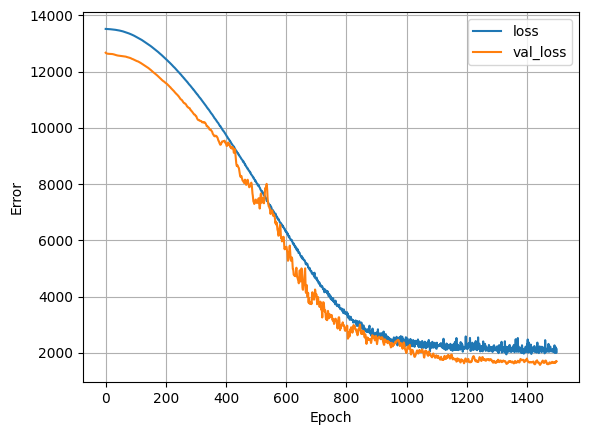

In [12]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

9/9 - 0s - loss: 1478.8824 - mae: 1478.8824 - mse: 19508578.0000 - 46ms/epoch - 5ms/step
Testing set Mean Abs Error: 1478.88 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 3ms/step


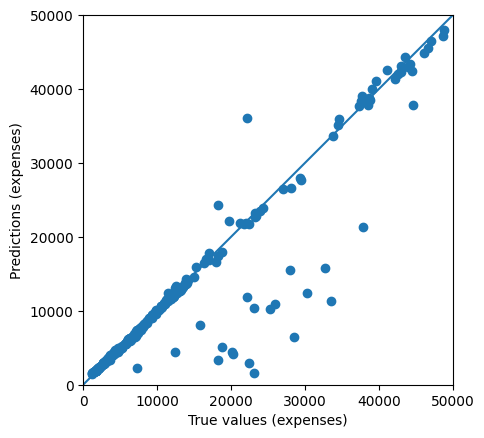

In [13]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
